In [1]:
from snn_delays.datasets.custom_datasets import CustomDataset
from snn_delays.config import DATASET_PATH
from torch.utils.data import DataLoader
import os

from snn_delays.utils.memory_cached_dataset import MemoryCachedDataset
import numpy as np

from snn_delays.snn_refactored import SNN
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple
from snn_delays.utils.test_behavior import tb_minimal
# from snn_delays.utils.visualization_utils import plot_taus
import numpy as np
device = get_device()

'''
3-letter classification dataset (permuted without repetition)

in total, 6 classes

'''

#data = np.load(os.path.join(DATASET_PATH, 'raw_datasets', 'Letters', 'letter_classification_dataset.npz'))
data = np.load(os.path.join(DATASET_PATH, 'Letters', 'three_permuted_letter_classification_dataset.npz'))

train_data = data['train_data']
test_data = data['test_data']
train_labels= data['train_labels']
test_labels = data['test_labels']

num_samples = len(train_labels)

train_dataset = CustomDataset(train_data, train_labels)
test_dataset = CustomDataset(test_data, test_labels)

dataset_dict = train_dataset.get_train_attributes()

cached_train_dataset = MemoryCachedDataset(train_dataset, device=device)
cached_test_dataset = MemoryCachedDataset(test_dataset, device=device)

total_time = train_data.shape[1]
print(f'num timesteps per sample: {total_time}')
batch_size = 128

train_loader = DataLoader(cached_train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=False,
                            pin_memory=False,
                            num_workers=0)

test_loader = DataLoader(cached_test_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=False,
                            pin_memory=False,
                            num_workers=0)

dataset_dict["time_ms"] = 1e3
dataset_dict["dataset_name"] = "letters"

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda:0
Initializing GPU cache for 2400 samples...
Cache initialized in 0.14 seconds
Initializing GPU cache for 600 samples...
Cache initialized in 0.01 seconds
num timesteps per sample: 48


In [2]:
num_h = 64

time_window = 48

tau_m = 'log-uniform-st'

snn_vf = SNN(dataset_dict, structure=(num_h, 2, 'f'), win=time_window, tau_m=tau_m,
             loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False)

snn_vf.set_layers()
snn_vf.to(device)


extra_kwargs = {'multifeedforward':3}
snn_f = SNN(dataset_dict, structure=(num_h, 2, 'mf'), win=time_window, tau_m=tau_m,
             loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_f.set_layers()
snn_f.to(device)

snn_rnn = SNN(dataset_dict, structure=(num_h, 2, 'r'), win=time_window, tau_m=tau_m,
               loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False)

snn_rnn.set_layers()
snn_rnn.to(device)

extra_kwargs = {'delay_range':(18, 1),
                'pruned_delays': 3}

snn_rd = SNN(dataset_dict, structure=(num_h, 2, 'd'), win=time_window, tau_m=tau_m,
               loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_rd.set_layers()
snn_rd.to(device)

Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms


SNN(
  (criterion): CrossEntropyLoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=25, out_features=64, bias=False)
    )
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=1152, out_features=64, bias=False)
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=6, bias=False)
    )
  )
)

In [3]:
a, b = snn_vf.test(test_loader)
a, b = snn_f.test(test_loader)
a, b = snn_rnn.test(test_loader)
a, b = snn_rd.test(test_loader)

600
Test Loss: 12.156386566162109
Avg spk_count per neuron for all 48 time-steps 283.19166666666666
Test Accuracy of the model on the test samples: 15.500

600
Test Loss: 8.196374988555908
Avg spk_count per neuron for all 48 time-steps 286.76666666666665
Test Accuracy of the model on the test samples: 19.500

600
Test Loss: 2.5001430988311766
Avg spk_count per neuron for all 48 time-steps 67.8475
Test Accuracy of the model on the test samples: 15.167

600
Test Loss: 7.433498191833496
Avg spk_count per neuron for all 48 time-steps 241.44583333333333
Test Accuracy of the model on the test samples: 19.000



Vanilla feedforward

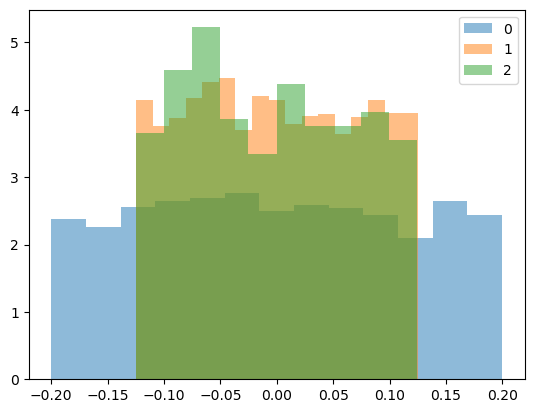

In [4]:
import matplotlib.pyplot as plt
from snn_delays.utils.visualization_utils import plot_param
for i, p in enumerate(snn_vf.layers):
    plot_param(p.linear, label=i)
plt.legend()

Multi Feedforward

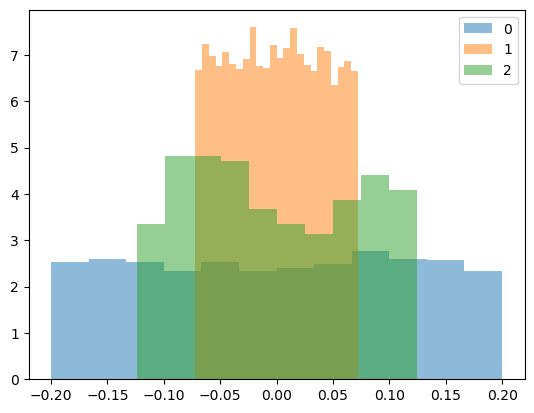

In [5]:
from snn_delays.utils.visualization_utils import plot_param
for i, p in enumerate(snn_f.layers):
    plot_param(p.linear, label=i)
plt.legend()

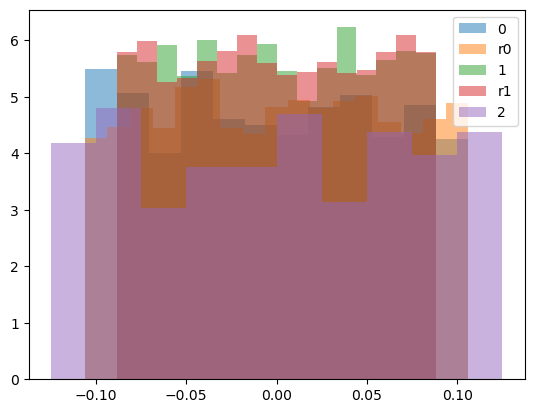

In [6]:
from snn_delays.utils.visualization_utils import plot_param
for i, p in enumerate(snn_rnn.layers[:-1]):
    plot_param(p.linear, label=i)
    plot_param(p.linear_rec, label='r'+str(i))
plot_param(snn_rnn.layers[-1].linear, label=2)
plt.legend()

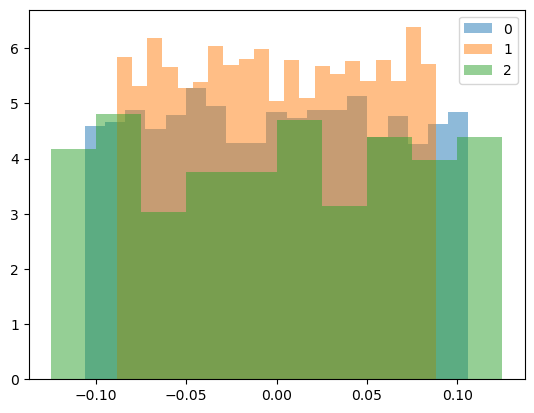

In [7]:
import torch
from snn_delays.utils.visualization_utils import plot_param
for i, p in enumerate(snn_rnn.layers[:-1]):
    conc = torch.concat((p.linear.weight.data.view(-1), p.linear_rec.weight.data.view(-1)))
    plot_param(conc, label=i)
plot_param(snn_rnn.layers[-1].linear, label=2)
plt.legend()


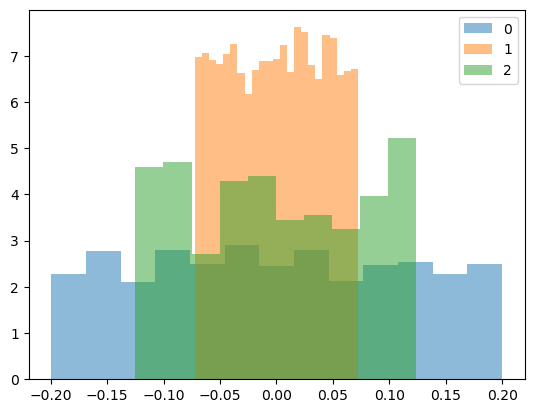

In [8]:
from snn_delays.utils.visualization_utils import plot_param
for i, p in enumerate(snn_rd.layers):
    plot_param(p.linear, label=i, mode='histogram_nonzero')
plt.legend()

In [9]:
snn_f.debug = True
snn_rnn.debug = True
snn_rd.debug = True
snn_vf.debug = True
snn_f.init_state_logger()
snn_rnn.init_state_logger()
snn_rd.init_state_logger()
snn_vf.init_state_logger()

In [10]:
def plot_activity(snn):

    images, _ = propagate_batch_simple(snn, test_loader)
    spk = snn.spike_state
    mem = snn.mem_state

    N = 0

    plt.figure(figsize=(6,9))

    plt.subplot(321)
    plt.imshow(images[N, :, 0, :].T.cpu().numpy(), aspect='auto')

    plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
    plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

    plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
    plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

    plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
    plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

    plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
    plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

    plt.tight_layout()
    plt.show()

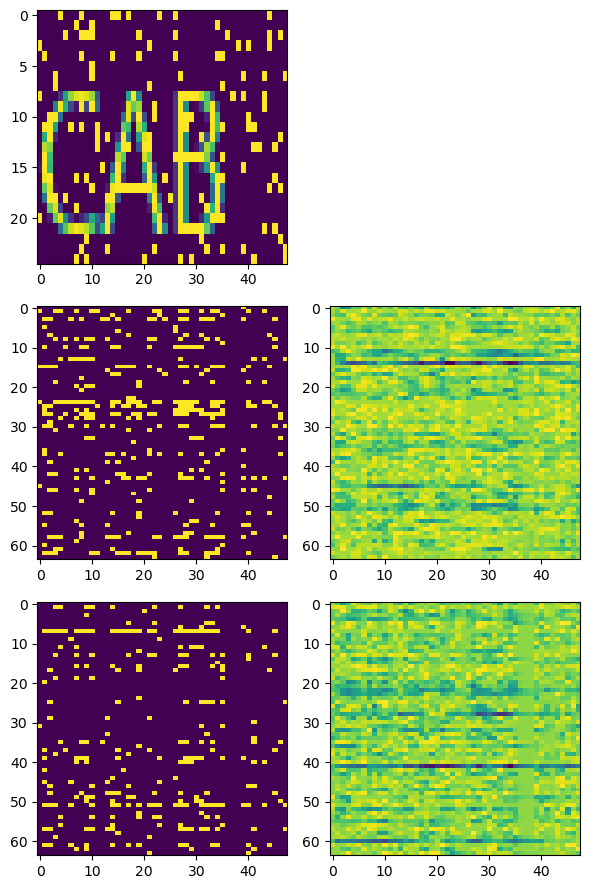

In [11]:
plot_activity(snn_vf)

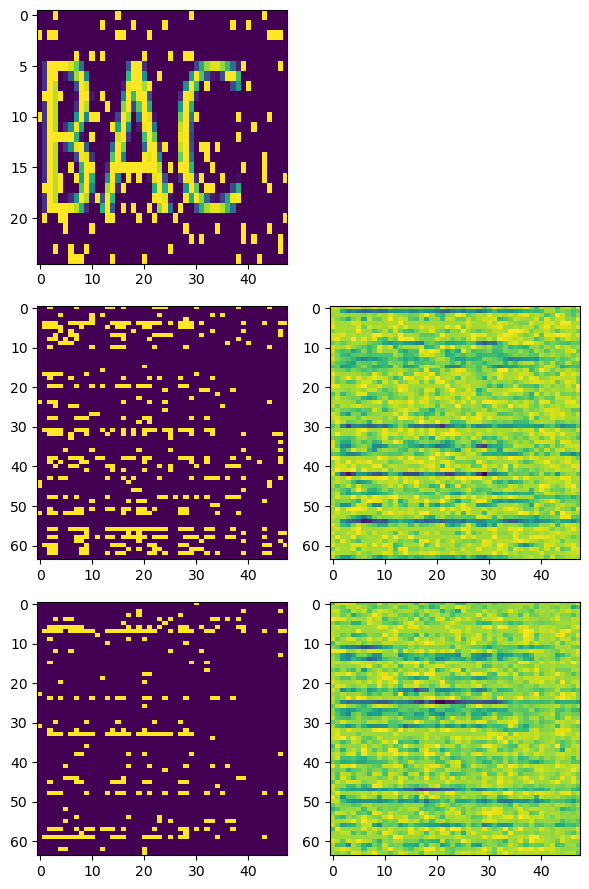

In [12]:
plot_activity(snn_f)

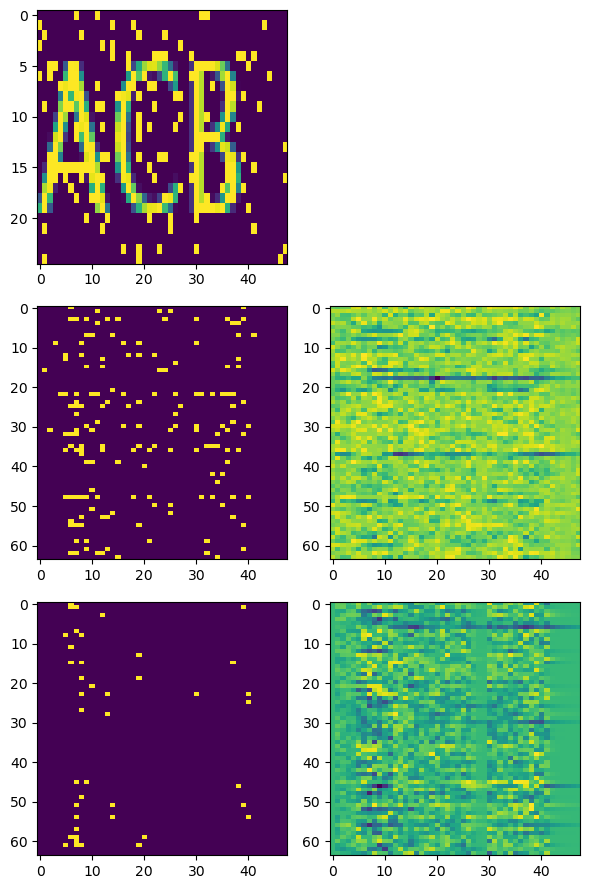

In [13]:
plot_activity(snn_rnn)

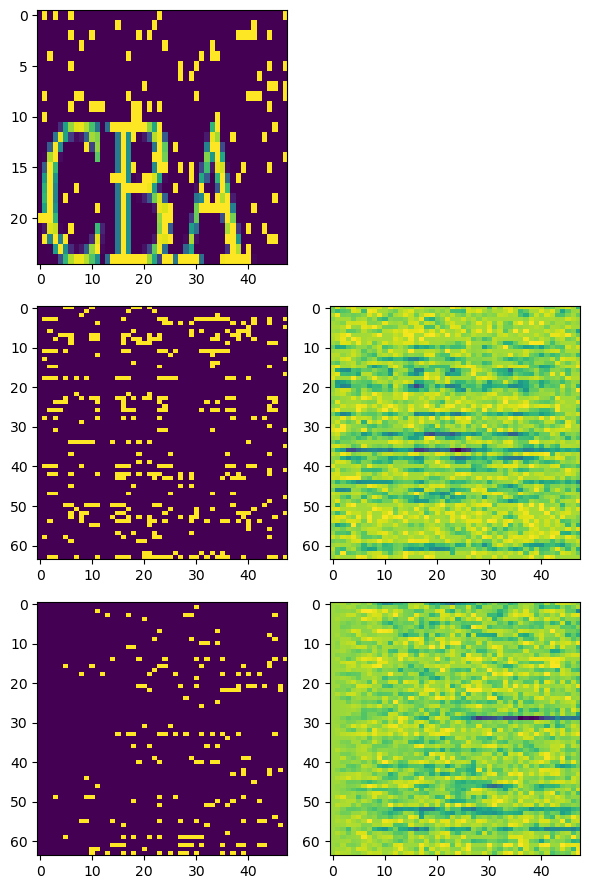

In [14]:
plot_activity(snn_rd)